In [ ]:
import tweepy
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, accuracy_score
from yellowbrick.text import TSNEVisualizer
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve

In [ ]:
# Key Token

mykeys = open('../API_key/apikey.txt', 'r').read().splitlines()

api_key = mykeys[0]
api_key_secret = mykeys[1]
access_token = mykeys[2]
access_token_secret = mykeys[3]
auth_hendler = tweepy.OAuthHandler(api_key, api_key_secret)
auth_hendler.set_access_token(access_token, access_token_secret)

In [ ]:
# Crawling data
api = tweepy.API(auth_hendler)

search_term = 'biznet'
tweet_amount = 1000
remove_rt = '-filter:retweets'
# Between two dates (just 10 day)
start_date = "2020-12-31"
end_date = "2020-11-30"
# Tweepy Cursor
tweets = tweepy.Cursor(api.search, q=search_term + remove_rt, lang='id', since=start_date).items()
# Pulling information from tweets iterable 
tweets_ = [[tweet.created_at,tweet.user.screen_name, tweet.user.location, tweet.text] for tweet in tweets]
#Make DataFrame for tweets after crawling
tweets_list = pd.DataFrame(data=tweets_, columns=['Date','Username','Location','Text'])
# Creation of dataframe from tweets list
tweets_df = pd.DataFrame(tweets_list)
tweets_df

In [ ]:
# Save data crawling to file .csv
tweets_df.to_csv('../Dataset/data_mentah.csv', index = False, header = True)

In [ ]:
# Open data file .csv
tweets_df = pd.read_csv('../Dataset/data_labels_skenario3 - Copy.csv', encoding='latin-1')


In [ ]:
tweets_df.drop(['Date','Username','Location'], axis=1, inplace=True)


In [ ]:
def remove_punctuation(text):
    # Happy Emoticons
    emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', ':d', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])
 
    # Sad Emoticons
    emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])
 
    # All emoticons (happy + sad)
    emoticons = emoticons_happy.union(emoticons_sad)
    
    text = ' '.join([word for word in text.split() if word not in emoticons])
    # Remove Username
    text = re.sub(r'@[\w]*', ' ', text)
    # Remove Punctuation
    text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', ' ', text)
    # Remove Link
    text = re.sub(r'^https?:\/\/.*[\r\n]*', ' ', text)
    # Remove RT
    text = re.sub(r'^RT[\s]+', ' ', text)  
    # Lower case
    text = text.lower()  
    # Remove 
    text = re.sub(r'[^\w\s]+', ' ', text)
    # Remove Number
    text = re.sub(r'[0-9]+', ' ', text)
    # Remove -
    text = re.sub(r'_', ' ', text)
    # Remove 
    text = re.sub(r'\$\w*', ' ', text)
    
    return text

stopwords_indonesia = stopwords.words('indonesian')
stp = stopwords.words('indonesian')
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in stp])
    return text


def stem_text(text):
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

In [ ]:
# Optional # Optional # Optional # Optional # Optional # Optional # Optional # Optional # Optional # Optional # Optional # Optional # Optional 
tweets_df['remove_punctuation'] = tweets_df['Text'].map(lambda x: remove_punctuation(x))
tweets_df

In [ ]:
# Optional # Optional # Optional # Optional # Optional # Optional # Optional # Optional # Optional # Optional # Optional # Optional # Optional 
tweets_df['remove_stopwords'] = tweets_df['remove_punctuation'].map(lambda x: remove_stopwords(remove_punctuation(x)))
tweets_df

In [ ]:
# For all step cleansing 
tweets_df['Text_bersih'] = tweets_df['Text'].map(lambda x: stem_text(remove_stopwords(remove_punctuation(x))))

In [ ]:
# Drop Column
tweets_df.drop(['Text'], axis=1, inplace=True)


In [ ]:
# Drop Duplicate
tweets_df.drop_duplicates(subset ="Text_bersih", keep = 'first', inplace = True)
tweets_df

In [13]:
# Open data file .csv
tweets_df = pd.read_csv('../Dataset/bersih.csv', encoding='latin-1')

In [14]:
# Check value counts of Labels
tweets_df['Labels'].value_counts()

positif    500
negatif    500
Name: Labels, dtype: int64

In [15]:
# Change labels positif to 0 and label negatif to 1
tweets_df['Labels'] = tweets_df['Labels'].map({'positif': 0, 'negatif': 1})
X = tweets_df['Text_bersih']
y = tweets_df['Labels']

In [ ]:
# Optional # Optional # Optional # Optional # Optional # Optional # Optional # Optional # Optional # Optional # Optional # Optional # Optional 
# For limit data sampel SKENARIO 1
s_1 = tweets_df[tweets_df['Labels']==1].sample(400,replace=True)
s_2 = tweets_df[tweets_df['Labels']==0].sample(400,replace=True)
tweets_df = pd.concat([s_1, s_2])
# Check value counts of Labels
tweets_df['Labels'].value_counts()

In [ ]:
# Optional # Optional # Optional # Optional # Optional # Optional # Optional # Optional # Optional # Optional # Optional # Optional # Optional 
# Polarity == 0 negative
train_s0 = tweets_df[tweets_df["Labels"] == 1]
all_text_s0 = ' '.join(word for word in train_s0["Text_bersih"])
wordcloud = WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text_s0)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

# Polarity == 1 positive
train_s1 = tweets_df[tweets_df["Labels"] == 0]
all_text_s1 = ' '.join(word for word in train_s1["Text_bersih"])
wordcloud = WordCloud(width=1000, height=1000, colormap='Blues', background_color='white', mode='RGBA').generate(all_text_s1)
plt.figure( figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

wf=wordcloud.words_

In [16]:
# Split data testing and training test_size testing 0.1(10%) of dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=13)

In [17]:
# Process TF-IDF
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [ ]:
# Optional # Optional # Optional # Optional # Optional # Optional # Optional # Optional # Optional # Optional # Optional # Optional # Optional
print(X_train)
print(X_test)

In [18]:
# Preprocessing and vectorizer for testing models
def preprocess_data(data):
    
    data = remove_punctuation(data)
    
    data = remove_stopwords(data)
    
    data = stem_text(data)

    data = vectorizer.transform([data])
    
    return data

In [19]:
# Process of making models Klasifikasi SVM LINEAR
linear = SVC(kernel="linear", gamma=1, C=1)
linear.fit(X_train,y_train)
linear1 = linear.predict(X_test)

In [20]:
# Process of making models Klasifikasi SVM RBF
rbf = SVC(kernel="rbf", gamma=1, C=1)

rbf.fit(X_train,y_train)
rbf1 = rbf.predict(X_test)

In [21]:
# F1_score
print("F1 score hasil prediksi adalah : ", f1_score(y_test, linear1))
# Accuracy score
print("Accuracy score hasil prediksi adalah : ", accuracy_score(y_test, linear1))
# Precision score
print("Precision score hasil prediksi adalah : ", precision_score(y_test, linear1))
# Recall score
print("Recall score hasil prediksi adalah : ", recall_score(y_test, linear1))
print('\n')
# F1_score
print("F1 score hasil prediksi adalah : ", f1_score(y_test, rbf1))
# Accuracy score
print("Accuracy score hasil prediksi adalah : ", accuracy_score(y_test, rbf1))
# Precision score
print("Precision score hasil prediksi adalah : ", precision_score(y_test, rbf1))
# Recall score
print("Recall score hasil prediksi adalah : ", recall_score(y_test, rbf1))

F1 score hasil prediksi adalah :  0.8837209302325582
Accuracy score hasil prediksi adalah :  0.9
Precision score hasil prediksi adalah :  0.9047619047619048
Recall score hasil prediksi adalah :  0.8636363636363636


F1 score hasil prediksi adalah :  0.8571428571428571
Accuracy score hasil prediksi adalah :  0.87
Precision score hasil prediksi adalah :  0.8297872340425532
Recall score hasil prediksi adalah :  0.8863636363636364


In [22]:
# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, linear1).ravel()
print("True Positive : ", tp)
# Accuracy score
print("True Negative : ", tn)
# Precision score
print("False Positive : ", fp)
# Recall score
print("False Negative  : ", fn)
print('\n')
# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, rbf1).ravel()
print("True Positive : ", tp)
# Accuracy score
print("True Negative : ", tn)
# Precision score
print("False Positive : ", fp)
# Recall score
print("False Negative  : ", fn)

True Positive :  38
True Negative :  52
False Positive :  4
False Negative  :  6


True Positive :  39
True Negative :  48
False Positive :  8
False Negative  :  5


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


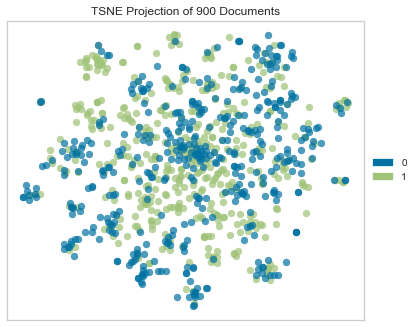

In [23]:
# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(X_train, y_train)
tsne.show()

In [ ]:
#Validation curve
param_range = np.logspace(-3, 2, 20)
train_scores, test_scores = validation_curve(SVC(kernel="linear", gamma=1, C=1), X_train, y_train, param_name='gamma', param_range=param_range, scoring="accuracy", n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM Kernel Linear")
plt.xlabel(r"$\gamma$ (gamma)")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
#fig2=plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color='navy', lw=lw)
#fig2.figure.savefig('fig2.png', bbox_inches='tight')
plt.legend(loc="best")
plt.show()

In [ ]:
#Validation curve
param_range = np.logspace(-3, 2, 20)
train_scores, test_scores = validation_curve(SVC(kernel="rbf", gamma=1, C=1), X_train, y_train, param_name='gamma', param_range=param_range, scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM Kernel RBF")
plt.xlabel(r"$\gamma$ (gamma)")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
#fig2=plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color='navy', lw=lw)
#fig2.figure.savefig('fig2.png', bbox_inches='tight')
plt.legend(loc="best")
plt.show()

In [ ]:
#Learning Curve
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(SVC(kernel="linear", gamma=1, C=1), X_train, y_train, cv=20, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve SVM Kernel Linear")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [ ]:
#Learning Curve
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(SVC(kernel="rbf", gamma=1, C=1), X_train, y_train, cv=20, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve SVM Kernel RBF")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [24]:
# Example Term
review_positif = "ganti biznet aja dari pada indihomo"
review_negatif = "biznet masalah mulu"

In [25]:
# Check prediction of term [0] for positif [1] for negatif
linear.predict(preprocess_data(review_positif))

array([0], dtype=int64)

In [26]:
# Check prediction of term [0] for positif [1] for negatif
linear.predict(preprocess_data(review_negatif))

array([1], dtype=int64)